In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
historical_temps_18801959 = pd.read_csv('../fully_connected_nn/preds_1880-1960_OUTSIDE.csv')
historical_temps_19602012 = pd.read_csv('../fully_connected_nn/preds_1960-2012_WITHIN.csv')

# this is the file we created by running our `fully_connected_1960.ipynb` on data observations in the range 1880 - 1960
historical_temps = pd.concat([historical_temps_18801959, historical_temps_19602012]).reset_index(drop=True)
historical_temps

,Unnamed: 0,year,temp_anom,pred
0,0,1880.0,-0.580696,-0.301994
1,1,1881.0,-0.437284,-0.304912
2,2,1882.0,-0.448660,-0.292852
3,3,1883.0,-0.535872,-0.288944
4,4,1884.0,-0.577859,-0.279507
...,...,...,...,...
128,48,2008.0,0.262481,0.423056
129,49,2009.0,0.351948,0.487363
130,50,2010.0,0.760148,0.333517
131,51,2011.0,0.519282,0.475413


In [10]:
# flip the arrays so that they're goin in reverse order, and will thus predict the past rather than the future
noaa_temp_anoms = np.flip(np.asarray(historical_temps['temp_anom']))
noaa_temp_anoms[:5], len(noaa_temp_anoms)

(array([0.49814306, 0.51928214, 0.76014816, 0.35194782, 0.26248107]), 133)

In [11]:
#Predict the next annual temp anomaly based off of the previous 4.
N = 133  # total unmber of records
Tp = 54 # train on 54 records, test on 79

In [12]:
noaa_train, noaa_test = noaa_temp_anoms[0:Tp], noaa_temp_anoms[Tp:N]

In [13]:
# predict the current year based on the past 4 years
step = 4
# add step elements into train and test
noaa_test = np.append(noaa_test,np.repeat(noaa_test[-1,],step))
noaa_train = np.append(noaa_train,np.repeat(noaa_train[-1,],step))

In [14]:
# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

In [15]:
noaa_trainX, noaa_trainY = convertToMatrix(noaa_train,step)
noaa_testX, noaa_testY = convertToMatrix(noaa_test,step)

In [16]:
noaa_trainX = np.reshape(noaa_trainX, (noaa_trainX.shape[0], 1, noaa_trainX.shape[1]))
noaa_testX = np.reshape(noaa_testX, (noaa_testX.shape[0], 1, noaa_testX.shape[1]))
noaa_testX.shape

(79, 1, 4)

In [17]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

In [21]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
# model.fit(noaa_trainX,noaa_trainY, epochs=100, batch_size=16, verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1184      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(noaa_trainX,noaa_trainY, epochs=100, batch_size=16, verbose=2)
trainPredict_noaa = model.predict(noaa_trainX)
testPredict_noaa= model.predict(noaa_testX)
predicted_noaa=np.concatenate((trainPredict_noaa,testPredict_noaa),axis=0)


Epoch 1/100
4/4 - 0s - loss: 0.0168
Epoch 2/100
4/4 - 0s - loss: 0.0168
Epoch 3/100
4/4 - 0s - loss: 0.0168
Epoch 4/100
4/4 - 0s - loss: 0.0167
Epoch 5/100
4/4 - 0s - loss: 0.0166
Epoch 6/100
4/4 - 0s - loss: 0.0165
Epoch 7/100
4/4 - 0s - loss: 0.0167
Epoch 8/100
4/4 - 0s - loss: 0.0168
Epoch 9/100
4/4 - 0s - loss: 0.0167
Epoch 10/100
4/4 - 0s - loss: 0.0168
Epoch 11/100
4/4 - 0s - loss: 0.0164
Epoch 12/100
4/4 - 0s - loss: 0.0164
Epoch 13/100
4/4 - 0s - loss: 0.0165
Epoch 14/100
4/4 - 0s - loss: 0.0165
Epoch 15/100
4/4 - 0s - loss: 0.0168
Epoch 16/100
4/4 - 0s - loss: 0.0165
Epoch 17/100
4/4 - 0s - loss: 0.0165
Epoch 18/100
4/4 - 0s - loss: 0.0164
Epoch 19/100
4/4 - 0s - loss: 0.0164
Epoch 20/100
4/4 - 0s - loss: 0.0164
Epoch 21/100
4/4 - 0s - loss: 0.0164
Epoch 22/100
4/4 - 0s - loss: 0.0164
Epoch 23/100
4/4 - 0s - loss: 0.0164
Epoch 24/100
4/4 - 0s - loss: 0.0166
Epoch 25/100
4/4 - 0s - loss: 0.0164
Epoch 26/100
4/4 - 0s - loss: 0.0162
Epoch 27/100
4/4 - 0s - loss: 0.0162
Epoch 28/1

In [22]:
#Next, we'll check the loss
trainScore = model.evaluate(noaa_trainX, noaa_trainY, verbose=0)
print(trainScore)
# put them in the right order again
predicted_noaa = np.flip(predicted_noaa)

0.04314137250185013


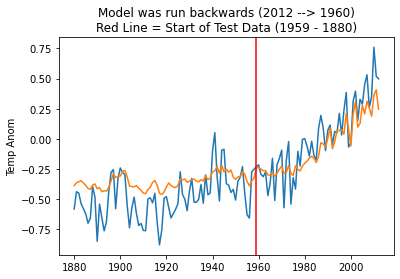

In [27]:
# Finally, we check the result in a plot. 
index = historical_temps['year'].values
#plt.plot(index,historical_temps['pred'], color = 'blue')
plt.plot(index,historical_temps['temp_anom'], color = 'C0')
plt.plot(index,predicted_noaa, color="C1")
# A vertical line in a plot identifies a splitting point between the training and the test part.
plt.axvline(historical_temps['year'][N - Tp], c="r")
plt.title('Model was run backwards (2012 --> 1960)\nRed Line = Start of Test Data (1959 - 1880)')
plt.ylabel('Temp Anom')
plt.show() 


In [33]:
compare_df = pd.DataFrame()
compare_df['year'] = historical_temps['year']
compare_df['predicted'] = predicted_noaa
compare_df['temp_anom'] = historical_temps['temp_anom']
compare_df

,year,predicted,temp_anom
0,1880.0,-0.385870,-0.580696
1,1881.0,-0.362405,-0.437284
2,1882.0,-0.354622,-0.448660
3,1883.0,-0.346220,-0.535872
4,1884.0,-0.364134,-0.577859
...,...,...,...
128,2008.0,0.257555,0.262481
129,2009.0,0.188949,0.351948
130,2010.0,0.364016,0.760148
131,2011.0,0.407930,0.519282


In [34]:
compare_df_past = compare_df[compare_df['year']<1960]
compare_df_past

,year,predicted,temp_anom
0,1880.0,-0.385870,-0.580696
1,1881.0,-0.362405,-0.437284
2,1882.0,-0.354622,-0.448660
3,1883.0,-0.346220,-0.535872
4,1884.0,-0.364134,-0.577859
...,...,...,...
75,1955.0,-0.353452,-0.628892
76,1956.0,-0.388137,-0.655931
77,1957.0,-0.347235,-0.272213
78,1958.0,-0.325913,-0.251039


In [36]:
from sklearn.metrics import mean_squared_error
mean_squared_error(compare_df_past['predicted'],compare_df_past['temp_anom'])

0.036500274251604396

In [37]:
np.var(compare_df_past['predicted']),np.var(compare_df_past['temp_anom'])

(0.003295841161161661, 0.03296224554920191)

In [38]:
np.corrcoef(compare_df_past['predicted'],compare_df_past['temp_anom'])

array([[1.        , 0.79479422],
       [0.79479422, 1.        ]])